In [69]:
%matplotlib inline
from pathlib import Path
import importlib
import matplotlib.pyplot as plt

import numpy as np
import chainer
from chainer import training, optimizer_hooks
from chainer.training import extensions
from sklearn.model_selection import train_test_split

from pycocotools.coco import COCO

In [60]:
from YOLOv3.lib.links.yolov3 import YOLOv3
from YOLOv3.lib.links.loss import YOLOv3Loss
from YOLOv3.lib.links.predict import YOLOv3Predictor

from src import Dataset
importlib.reload(Dataset)

<module 'src.Dataset' from '/home/kitamura/work/YOLO/src/Dataset.py'>

In [30]:
# モデルの用意

n_class = 2
base = None # default is yolo
ignore_thresh = 0.5
device = -1 # cpu (< 0) or gpu (>= 0)

yolov3 = YOLOv3(n_class, None, ignore_thresh)
model = YOLOv3Loss(yolov3)

optimizer = chainer.optimizers.MomentumSGD(lr=0.001)
optimizer.setup(model)
optimizer.add_hook(optimizer_hooks.WeightDecay(0.0005), "hook_decay")
optimizer.add_hook(optimizer_hooks.GradientClipping(10.0), "hook_grad_clip")

In [61]:
# データの用意
dataset_path = Path.home() / Path("work/dataset/COCO/")
batchsize = 8
category_names = ["bicycle", "car"]

dataset = Dataset.load_dataset(dataset_path, category_names=category_names)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=0)
train, test = Dataset.YOLODataset(train_dataset[:96]), Dataset.YOLODataset(test_dataset[:24])

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

loading annotations into memory...
Done (t=10.03s)
creating index...
index created!


In [73]:
# トレーニングの構築

iteration = 960
output_dir = "result"
display_interval = (1, 'iteration')
snapshot_interval = (480, 'iteration')

if not Path(output_dir).exists():
    Path(output_dir).mkdir()

updater = training.StandardUpdater(train_iter, optimizer, converter=Dataset.concat_yolo, device=device)
trainer = training.Trainer(updater, (iteration, 'iteration'), out=output_dir)

trainer.extend(extensions.Evaluator(test_iter, model, converter=Dataset.concat_yolo, device=device),
               trigger=display_interval)
trainer.extend(extensions.dump_graph("main/loss"))
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'main/loss', 'validation/main/loss', 'elapsed_time']),
    trigger=display_interval)
trainer.extend(extensions.snapshot_object(yolov3, "yolov3_snapshot_epoch-{.updater.epoch}"),
               trigger=snapshot_interval)

In [33]:
dataset[2]

[PosixPath('/home/kitamura/work/dataset/COCO/train2014/COCO_train2014_000000032773.jpg'),
 [[595.47, 320.7, 44.53, 32.42]],
 [1]]

In [74]:
trainer.run()

b = 0, mask_n = 2, label = 1, i = 8, j = 11
[8, 3, 2, 16, 16, 0, 0, 0]
b = 0, mask_n = 2, label = 1, i = 10, j = 18
[8, 3, 2, 32, 32, 0, 0, 0]
b = 0, mask_n = 1, label = 1, i = 8, j = 25
[8, 3, 2, 32, 32, 0, 0, 0]


/home/kitamura/work/YOLO/YOLOv3/lib/links/yolo.py:157: RuntimeWarning: overflow encountered in exp
  tbox, tlabel)
/home/kitamura/work/YOLO/YOLOv3/lib/links/yolo.py:157: RuntimeWarning: overflow encountered in double_scalars
  tbox, tlabel)


b = 2, mask_n = 0, label = 1, i = 1, j = 3
[8, 3, 2, 16, 16, 0, 0, 0]
b = 2, mask_n = 1, label = 1, i = 2, j = 2
[8, 3, 2, 32, 32, 0, 0, 0]
b = 0, mask_n = 2, label = 0, i = 9, j = 48
[8, 3, 2, 64, 64, 0, 0, 0]
b = 0, mask_n = 0, label = 1, i = 13, j = 5
[8, 3, 2, 32, 32, 0, 0, 0]
b = 2, mask_n = 2, label = 1, i = 21, j = 5
[8, 3, 2, 32, 32, 0, 0, 0]
epoch       iteration   main/loss   validation/main/loss  elapsed_time
0           1           2004.26     8502.6                163.546       
b = 4, mask_n = 0, label = 1, i = 3, j = 12
[8, 3, 2, 16, 16, 0, 0, 0]
b = 3, mask_n = 1, label = 1, i = 7, j = 20
[8, 3, 2, 32, 32, 0, 0, 0]
b = 3, mask_n = 1, label = 1, i = 6, j = 17
[8, 3, 2, 32, 32, 0, 0, 0]
b = 2, mask_n = 0, label = 1, i = 3, j = 12
[8, 3, 2, 16, 16, 0, 0, 0]
b = 0, mask_n = 1, label = 0, i = 5, j = 5
[8, 3, 2, 32, 32, 0, 0, 0]
b = 2, mask_n = 1, label = 1, i = 6, j = 26
[8, 3, 2, 32, 32, 0, 0, 0]
b = 2, mask_n = 2, label = 1, i = 8, j = 54
[8, 3, 2, 64, 64, 0, 0, 0]
b = 2, 

KeyboardInterrupt: 

In [59]:
%matplotlib notebook
for i, batch in enumerate(train_iter):
    for j, data in enumerate(batch):
        image, _, _ = data
        if len(image.shape) == 2:
            print("batch : {}, num : {}, shape : {}".format(i, j, image.shape))
            plt.imshow(image)
            break
    else:
        continue
    break
plt.show()

(510, 640)
(640, 499)
(640, 499)
(510, 640)
(510, 640)
(640, 499)
(640, 499)
(510, 640)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(640, 499)
(510, 640)
(640, 499)


ValueError: not enough values to unpack (expected 3, got 0)

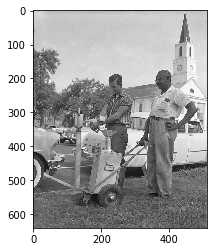

In [72]:
from PIL import Image

for data in dataset:
    image, _ , _ = data
    image = np.asarray(Image.open(image))
    if len(image.shape) == 2:
        plt.imshow(image, cmap="gray")
        break
        
plt.show()

In [ ]:
# デバッグ、プロット
thresh = 0.5
detector = YOLOv3Predictor(yolov3, thresh)

image, bboxes, labels = test_dataset[0]
detection = detector(image[np.newaxis, :, :, :])[0]

fig = plt.figure())
ax = plt.axes()

Plot.plot_image_and_bbox(ax, detection['box'], detection['prob'])
plt.show()

In [ ]:
# テスト・検証

